In [3]:
!pip install transformers

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
warnings.filterwarnings('ignore')

In [5]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Training 2000 sentences 

In [24]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None).head(2000)

In [25]:
# unique_intent = df['specific_intent'].unique()
# unique_intent

In [26]:
df.columns=['Sentences','Labels']

In [27]:
df['Labels'] = df['Labels'].apply(lambda x : "Not Affected" if x == 1 else 'Affected')

In [28]:
df.head(10)

,Sentences,Labels
0,"a stirring , funny and finally transporting re...",Not Affected
1,apparently reassembled from the cutting room f...,Affected
2,they presume their audience wo n't sit still f...,Affected
3,this is a visually stunning rumination on love...,Not Affected
4,jonathan parker 's bartleby should have been t...,Not Affected
5,campanella gets the tone just right funny in t...,Not Affected
6,a fan film that for the uninitiated plays bett...,Affected
7,"b art and berling are both superb , while hupp...",Not Affected
8,"a little less extreme than in the past , with ...",Affected
9,the film is strictly routine,Affected


In [29]:
import re 
def clean_data(Tweets):
    count = 0

    Tweets_cleaned = []

    # rules for elements being eliminated from the tweets
    r_at = r'@[A-Za-z0-9_]+'  # Removing @ from all tweets
    r_hash = r'#[A-Za-z0-9_]+' # Removing hash tags
    r_rt = r'RT '  # Removing RT i.e. if the tweet is a retweet
    r_emoji = '[^a-zA-Z]'  # Removing emoji and replacing with space
    #r_brandtag=r'#'+brand.lower()
    
    tokens=[]
    r_se = r'[:]]'
    r_se2 = r'[=)]'
    r_se3 = r'[:-D]'
    r_se4 = r'[:D]'
    r_se5 = r'[=D]'
    r_se6 = r'[:)]'

    r_sae2 = r'[:(]'
    r_sae3 = r'[:[]'
    r_sae4 = r'[=(]'
    
    r_ae = r'[>:(]'
    r_ae2 = r'[>:(]'
    
    r_le = r'[(y)]'
    r_le2 = r'[(Y)]'
    
    for t in Tweets:
        
        
        clean_tweets = re.sub(r'|'.join((r_at, r_rt)),'',t)  
        
        clean_tweets = re.sub('https?:[A-Za-z0-9./]+','URL',clean_tweets)
        clean_tweets = re.sub(r_hash, ' ', clean_tweets)
        clean_tweets = re.sub(r_emoji, ' ', clean_tweets)
        clean_tweets = re.sub('[\s ]+', ' ',clean_tweets)
        clean_tweets = clean_tweets.lower()
  
        Tweets_cleaned.append(clean_tweets)

    return Tweets_cleaned#, tokens

In [30]:
cleaned_sentences = clean_data(list(df['Sentences']))

In [31]:
cleaned_sentences[0:10]

['a stirring funny and finally transporting re imagining of beauty and the beast and s horror films',
 'apparently reassembled from the cutting room floor of any given daytime soap',
 'they presume their audience wo n t sit still for a sociology lesson however entertainingly presented so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes',
 'this is a visually stunning rumination on love memory history and the war between art and commerce',
 'jonathan parker s bartleby should have been the be all end all of the modern office anomie films',
 'campanella gets the tone just right funny in the middle of sad in the middle of hopeful',
 'a fan film that for the uninitiated plays better on video with the sound turned down',
 'b art and berling are both superb while huppert is magnificent',
 'a little less extreme than in the past with longer exposition sequences between them and with fewer gags to break the tedium',
 'the film i

In [32]:
batch = pd.DataFrame()
batch['cleaned_sentences'] = cleaned_sentences
batch['labels'] = df['Labels']
batch.head(10)

,cleaned_sentences,labels
0,a stirring funny and finally transporting re i...,Not Affected
1,apparently reassembled from the cutting room f...,Affected
2,they presume their audience wo n t sit still f...,Affected
3,this is a visually stunning rumination on love...,Not Affected
4,jonathan parker s bartleby should have been th...,Not Affected
5,campanella gets the tone just right funny in t...,Not Affected
6,a fan film that for the uninitiated plays bett...,Affected
7,b art and berling are both superb while hupper...,Not Affected
8,a little less extreme than in the past with lo...,Affected
9,the film is strictly routine,Affected


In [36]:
batch['labels'].value_counts()

Not Affected    1041
Affected         959
Name: labels, dtype: int64

lOADING PRE-TRAINED MODEL

In [37]:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [38]:
X_train, X_test, y_train, y_test  = train_test_split(batch['cleaned_sentences'], batch['labels'],test_size=0.10)

# **TRAIN_BERT**

In [39]:
tokenized_Train = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized_Train.values:
    if len(i) > max_len:
        max_len = len(i)

padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_Train.values])
print(padded_train[0])
np.array(padded_train).shape
attention_mask_train = np.where(padded_train != 0, 1, 0)
print(attention_mask_train.shape)
input_ids = torch.tensor(padded_train)  
attention_mask_train = torch.tensor(attention_mask_train)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask_train)
features = last_hidden_states[0][:,0,:].numpy()
bert_X_train = features

[  101  2195  4895 18447 18702  3436  4406  3085  2111  2079  2919  2477
  2000  1998  2007  2169  2060  1999  4895  7011  8939  3993   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
(1800, 56)


# **BERT_TEST**

In [40]:
tokenized_test = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
print(padded_test[0])
np.array(padded_test).shape
attention_mask_test = np.where(padded_test != 0, 1, 0)
print(attention_mask_test.shape)
input_ids = torch.tensor(padded_test)  
attention_mask_test = torch.tensor(attention_mask_test)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask_test)
features = last_hidden_states[0][:,0,:].numpy()
bert_X_test = features

[  101  9020  2000 12208  2302  2172  1997  1037  2466   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
(200, 51)


# SVM classifier

In [41]:
from sklearn import model_selection
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [42]:
classifier = svm.LinearSVC()
classifier.fit(bert_X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [43]:
y_pred = list(classifier.predict(bert_X_test))


In [44]:
print(X_test[1:10])

1777    in the new release of cinema paradiso the tale...
1196    to build a feel good fantasy around a vain dic...
1468    this quiet introspective and entertaining inde...
1598    this is an ungainly movie ill fitting with its...
1395    it s about as convincing as any other arnie mu...
607                overwrought melodramatic bodice ripper
1394    anyone who welcomes a dash of the avant garde ...
62      it s a square sentimental drama that satisfies...
1296                         david spade as citizen kane 
Name: cleaned_sentences, dtype: object


In [45]:
print(y_test[1:10])
print(y_pred[1:10])


1777    Not Affected
1196        Affected
1468    Not Affected
1598        Affected
1395        Affected
607         Affected
1394    Not Affected
62      Not Affected
1296        Affected
Name: labels, dtype: object
['Not Affected', 'Affected', 'Not Affected', 'Affected', 'Affected', 'Affected', 'Not Affected', 'Not Affected', 'Not Affected']


# **TESTING INPUT DATA**

# **# Confusion matrix**

In [46]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)


# print('Training score:',classifier.score(X_train, y_train))
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:" , test_accuracy)
print('\n')
print(cr)

Test accuracy: 0.825


              precision    recall  f1-score   support

    Affected       0.81      0.82      0.82        96
Not Affected       0.83      0.83      0.83       104

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.83       200



In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

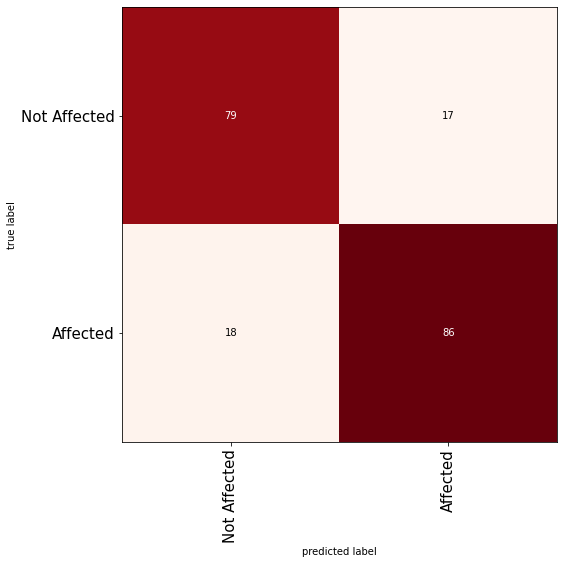

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(len(pd.unique(df['Labels']))), df['Labels'], fontsize=15)
plt.yticks(range(len(pd.unique(df['Labels']))), df['Labels'], fontsize=15)
plt.xticks(rotation=90)
plt.show()

## **TOKENIZER FOR TESTING**

In [51]:
def predict_tokenizer(series):
  tokenized_predict = series.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized_predict.values:
      if len(i) > max_len:
          max_len = len(i)

  padded1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_predict.values])
  attention_mask1 = np.where(padded1 != 0, 1, 0)
  input_ids1 = torch.tensor(padded1)  
  attention_mask1 = torch.tensor(attention_mask1)

  with torch.no_grad():
    last_hidden_states1 = model(input_ids1, attention_mask=attention_mask1)  
  features1 = last_hidden_states1[0][:,0,:].numpy()
  label1 = classifier.predict(features1)
  return label1[0]

# **Testing Data**

In [50]:
# sentence = str(input('Enter sentence: '))
# series = pd.Series(sentence)
# Predict_features = predict_tokenizer(series)
# print(Predict_features)

In [70]:
df_test = pd.read_excel('Precautions.xlsx')


# Using only 2000 rows

In [78]:
df_test = df_test[['content']].head(2000)

In [79]:
df_test.shape

(2000, 1)

In [84]:
cleaned_sentences = clean_data(list(df_test['content']))
cleaned_sentences[0:10]

['update temperatures overnight and into tomorrow afternoon have warmed up slightly overnight lows are in the s and s while tomorrow s afternoon highs will be in the s and s url',
 ' url',
 'nws fcst thisafternoonsunny hi f tonightmstly cloudy then patchy fog lo f sunmstly cloudy then slight chc light rain hi f url ',
 ' url',
 'good advice for those in the counties the major disaster declaration declared covers but we re still not sure what will happen to the impacted counties he forgot about url url',
 ' url',
 ' url',
 ' url',
 'it won t be near as cold tonight we will avoid dropping into the s for the first time in nearly two weeks url',
 'patchy fog and light drizzle sunday morning a cold front sunday afternoon brings low rain chances and strong wind gusts but plenty of sunshine this week with temps in the s and s full forecast url live stream url url']

In [87]:
predict_list = []
for i in cleaned_sentences:
    # print(i)
    series = pd.Series(i)
    predicted_intent = predict_tokenizer(series)
    predict_list.append(predicted_intent)
    
    
    

In [90]:
predict_list[0:10]

['Affected',
 'Not Affected',
 'Affected',
 'Not Affected',
 'Affected',
 'Not Affected',
 'Not Affected',
 'Not Affected',
 'Not Affected',
 'Affected']

In [91]:
df_test['sentiment'] = predict_list

In [92]:
df_test.head(10)

,content,sentiment
0,Update: Temperatures overnight and into tomorr...,Affected
1,👀 #txwx https://t.co/0ABcjEgjQd,Not Affected
2,"NWS fcst: ThisAfternoonSunny : , Hi 59°F; Toni...",Affected
3,* #TEXAS: #winterstorm2021 #winterstorm2021 \n...,Not Affected
4,Good advice for those in the 77 counties the M...,Affected
5,* #TEXAS: #winterstorm2021 #winterstorm2021 \n...,Not Affected
6,* @GovAbbott @GregAbbott_TX\n#Texas #AngelinaC...,Not Affected
7,*#TEXAS / #EastTexas: #WinterStorm #Snow\n-#L...,Not Affected
8,It won't be near as cold tonight! We will avoi...,Not Affected
9,Patchy fog and light drizzle Sunday morning. A...,Affected


In [93]:

data_count = df_test.groupby('sentiment').count()


In [94]:
data_count['content']

sentiment
Affected        1376
Not Affected     624
Name: content, dtype: int64

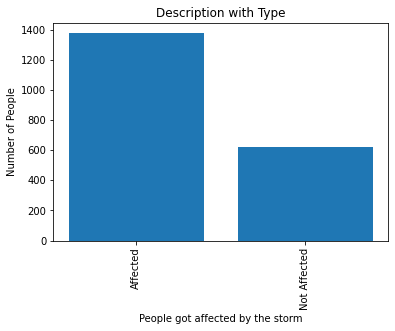

In [95]:
plt.bar(data_count.index.values,data_count['content'])
plt.title('Description with Type')
plt.xlabel('People got affected by the storm')
plt.ylabel('Number of People')
plt.plot()
plt.xticks(rotation=90)
plt.show()